In [18]:
!source mlproject/bin/activate

'source' is not recognized as an internal or external command,
operable program or batch file.


In [19]:
pip install pandas numpy matplotlib scikit-learn seaborn jupyterlab

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
pip install imblearn xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# For preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score

# For feature selection
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.linear_model import Lasso, LogisticRegression

# For handling imbalanced data
from imblearn.over_sampling import SMOTE

# For modeling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier

# For evaluation
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             confusion_matrix, classification_report, roc_auc_score, roc_curve)

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("All libraries imported successfully!")

All libraries imported successfully!


## Phase 1: Exploratory Data Analysis 

In [22]:
url = 'https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv'

try:
    df = pd.read_csv(url)
    print("Dataset loaded successfully from URL!")
except:
    print("Failed to load from URL. Please download the dataset manually.")
    print("Download from: https://www.kaggle.com/datasets/blastchar/telco-customer-churn")
    # Uncomment and use local file if download is needed
    # df = pd.read_csv('Telco-Customer-Churn.csv')

print(f"\nDataset Shape: {df.shape}")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

Dataset loaded successfully from URL!

Dataset Shape: (7043, 21)
Rows: 7043, Columns: 21


In [23]:
# Basic Information about the dataset
print("="*80)
print("DATASET BASIC INFORMATION")
print("="*80)

# Display first few rows
print("\n📊 First 5 rows:")
print(df.head())

print("\n" + "="*80)
print("\n📋 Dataset Info:")
print(df.info())

print("\n" + "="*80)
print("\n📈 Statistical Summary:")
print(df.describe())

print("\n" + "="*80)
print("\n🔍 Data Types:")
print(df.dtypes.value_counts())

print("\n" + "="*80)
print("\n📌 Column Names:")
print(df.columns.tolist())

DATASET BASIC INFORMATION

📊 First 5 rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport Strea

DATA QUALITY CHECK

🔄 Duplicate Rows: 0

❓ Missing Values per Column:
Empty DataFrame
Columns: [Missing Count, Percentage]
Index: []
✅ No missing values detected!


🎯 Target Variable Distribution (Churn):
Churn
No     5174
Yes    1869
Name: count, dtype: int64

📊 Proportion:
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


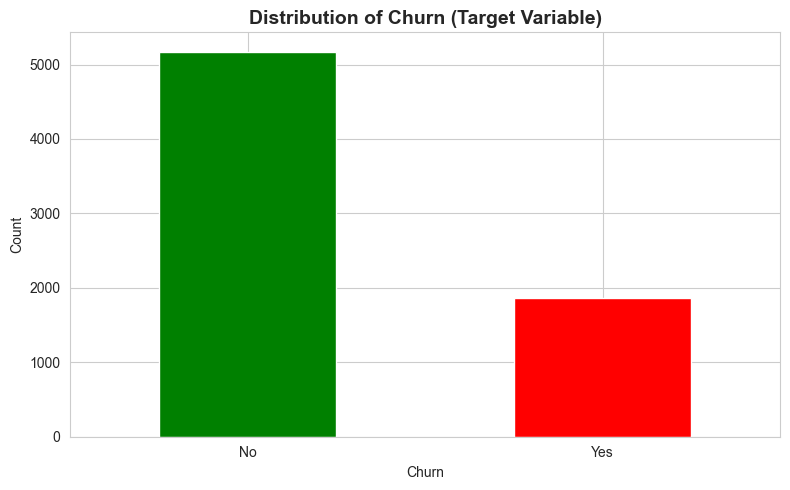

In [24]:
# Check for duplicates and missing values
print("="*80)
print("DATA QUALITY CHECK")
print("="*80)

print(f"\n🔄 Duplicate Rows: {df.duplicated().sum()}")
if df.duplicated().sum() > 0:
    print(f"Removing {df.duplicated().sum()} duplicate rows...")
    df = df.drop_duplicates()
    print(f"New shape: {df.shape}")

print(f"\n❓ Missing Values per Column:")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
}).sort_values(by='Missing Count', ascending=False)
print(missing_df[missing_df['Missing Count'] > 0])

if missing_df['Missing Count'].sum() == 0:
    print("✅ No missing values detected!")

print("\n" + "="*80)
print("\n🎯 Target Variable Distribution (Churn):")
print(df['Churn'].value_counts())
print("\n📊 Proportion:")
print(df['Churn'].value_counts(normalize=True))

# Visualize target distribution
plt.figure(figsize=(8, 5))
df['Churn'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Distribution of Churn (Target Variable)', fontsize=14, fontweight='bold')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Univariate Analysis 

In [25]:
# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Remove target variable and customerID from lists if present
if 'Churn' in categorical_cols:
    categorical_cols.remove('Churn')
if 'customerID' in categorical_cols:
    categorical_cols.remove('customerID')
if 'customerID' in numerical_cols:
    numerical_cols.remove('customerID')

print(f"📊 Numerical Columns ({len(numerical_cols)}): {numerical_cols}")
print(f"📋 Categorical Columns ({len(categorical_cols)}): {categorical_cols}")

📊 Numerical Columns (3): ['SeniorCitizen', 'tenure', 'MonthlyCharges']
📋 Categorical Columns (16): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges']


HISTOGRAMS FOR NUMERICAL VARIABLES


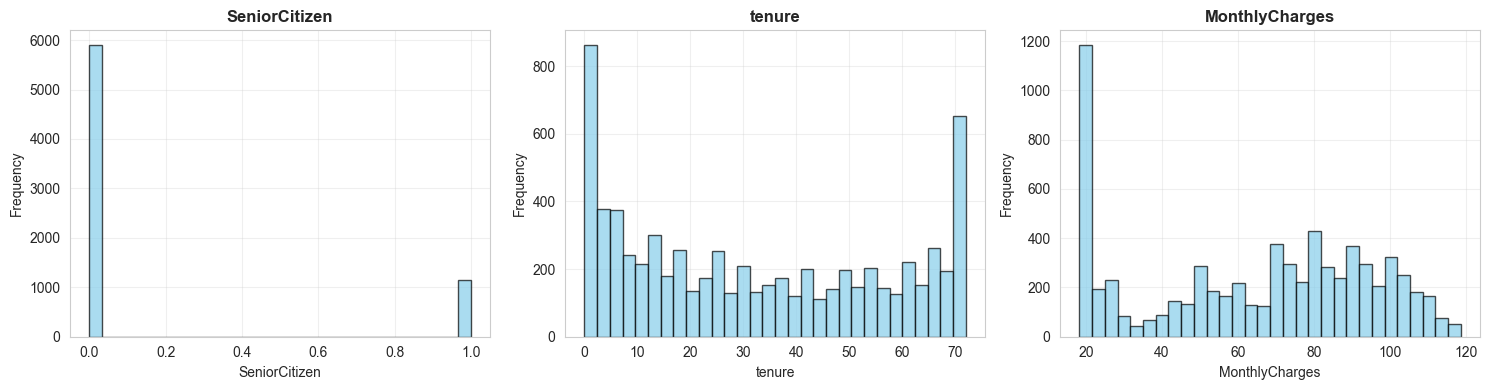


📈 Statistics for Numerical Variables:
       SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000


In [26]:
# Histograms for Numerical Variables
print("="*80)
print("HISTOGRAMS FOR NUMERICAL VARIABLES")
print("="*80)

fig, axes = plt.subplots(1, len(numerical_cols), figsize=(15, 4))
if len(numerical_cols) == 1:
    axes = [axes]

for idx, col in enumerate(numerical_cols):
    axes[idx].hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    axes[idx].set_title(f'{col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Display statistics for numerical variables
print("\n📈 Statistics for Numerical Variables:")
print(df[numerical_cols].describe())

BAR PLOTS FOR CATEGORICAL VARIABLES


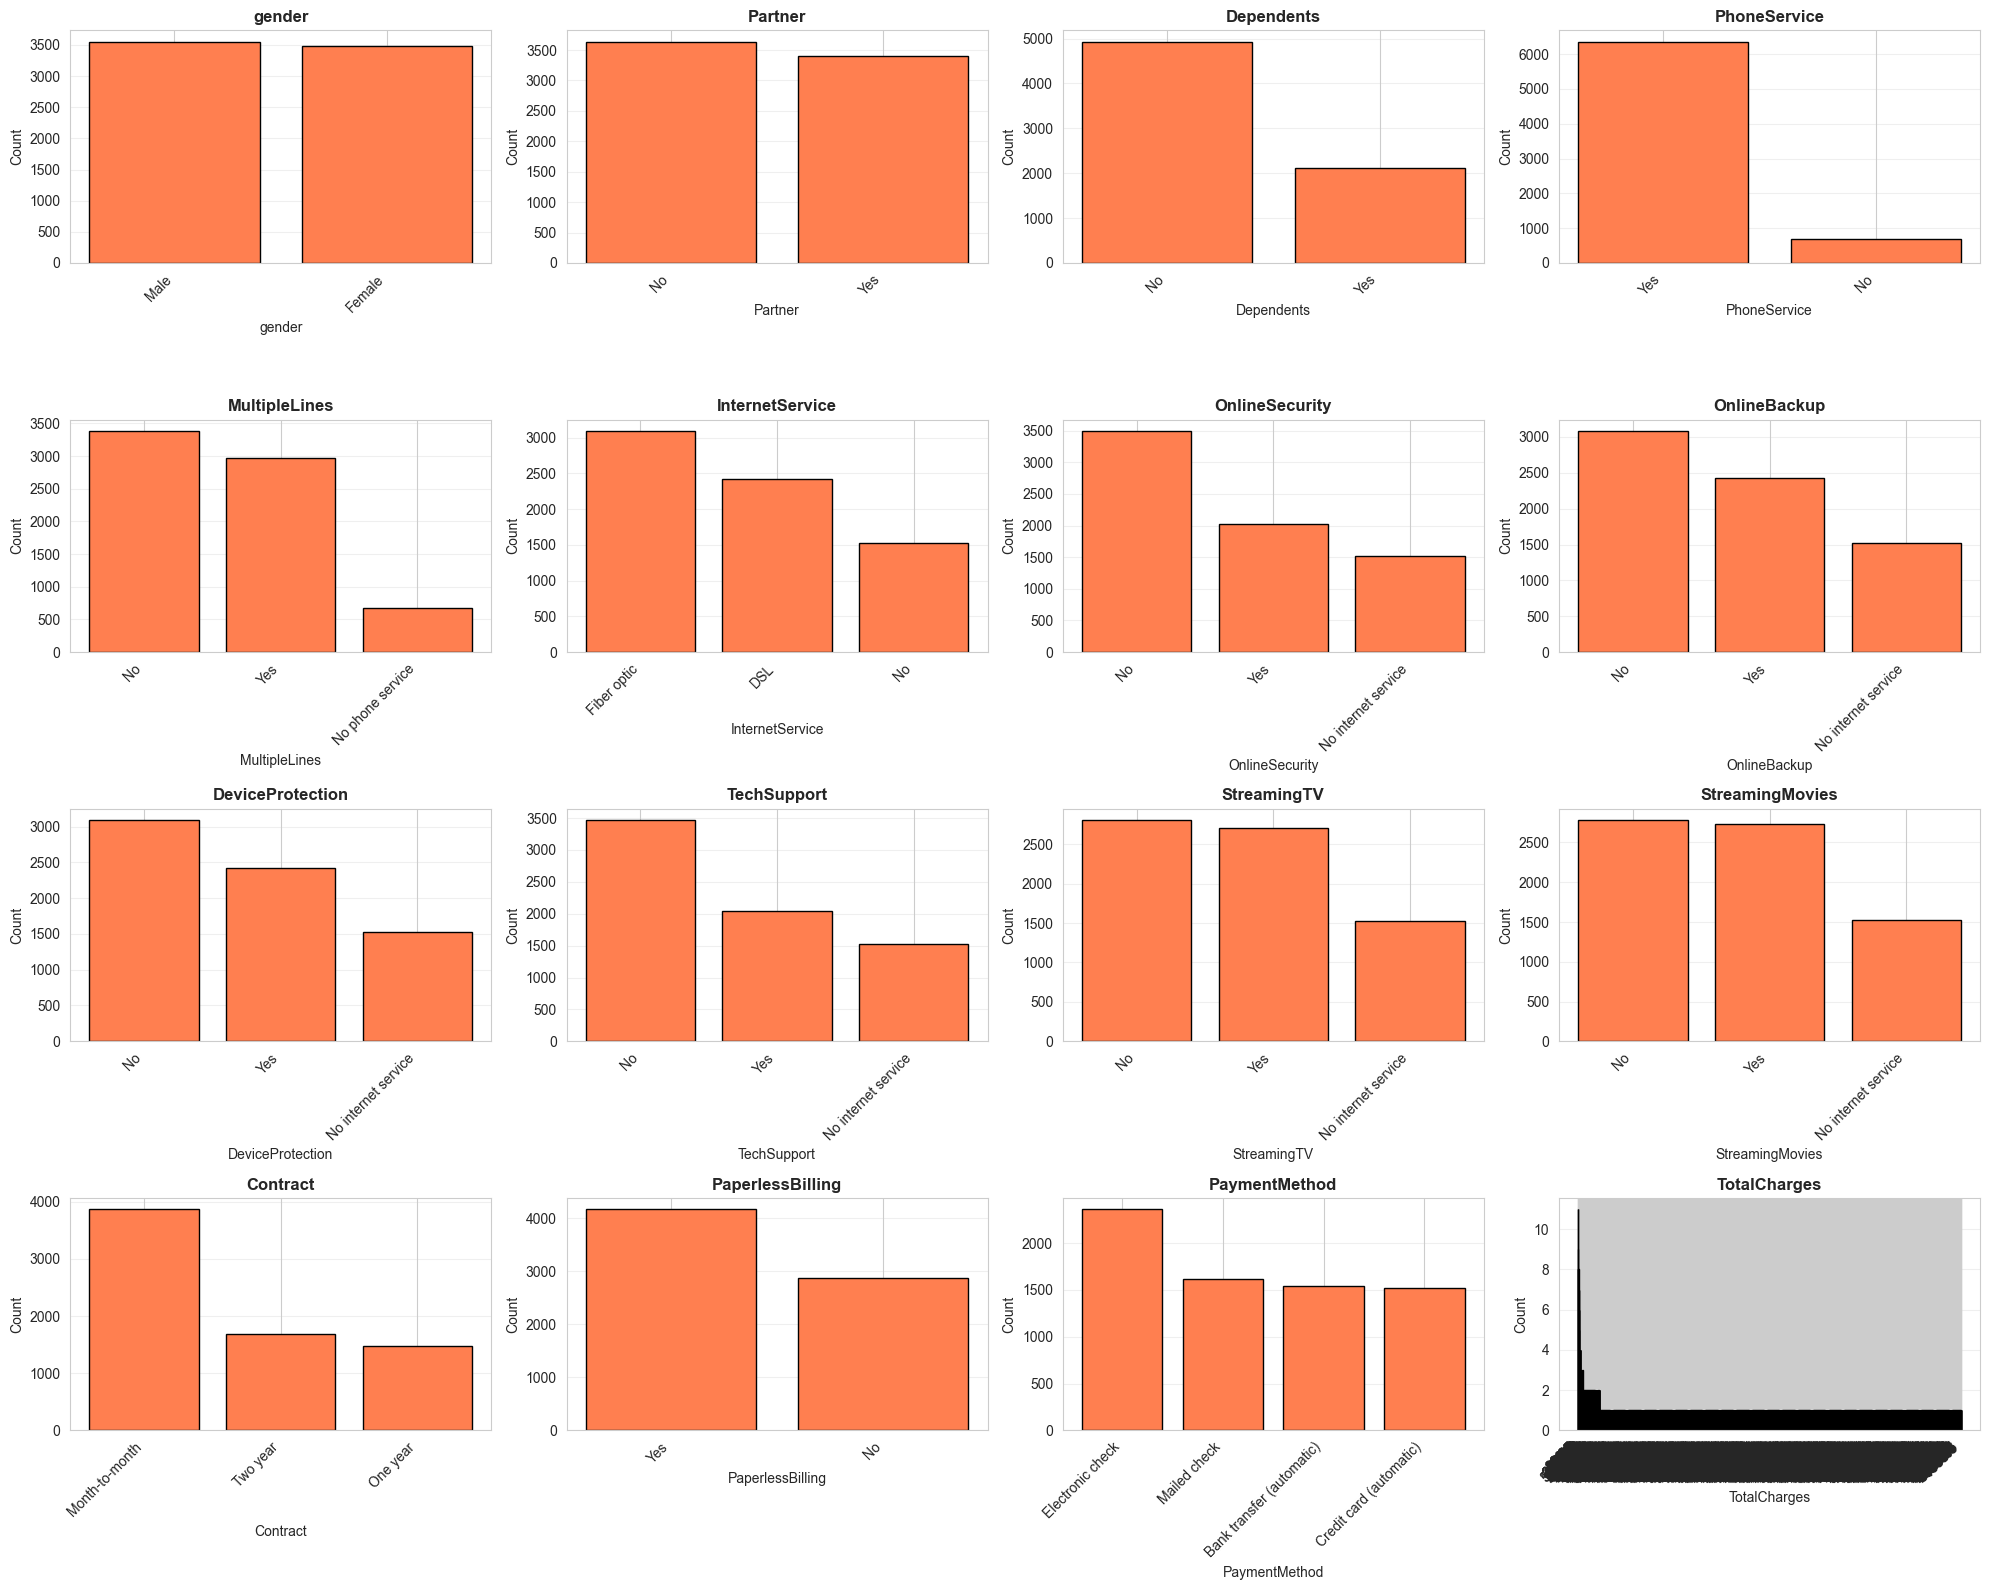


📊 Unique values per categorical variable:
gender: 2 unique values
Partner: 2 unique values
Dependents: 2 unique values
PhoneService: 2 unique values
MultipleLines: 3 unique values
InternetService: 3 unique values
OnlineSecurity: 3 unique values
OnlineBackup: 3 unique values
DeviceProtection: 3 unique values
TechSupport: 3 unique values
StreamingTV: 3 unique values
StreamingMovies: 3 unique values
Contract: 3 unique values
PaperlessBilling: 2 unique values
PaymentMethod: 4 unique values
TotalCharges: 6531 unique values


In [27]:
# Bar Plots for Categorical Variables
print("="*80)
print("BAR PLOTS FOR CATEGORICAL VARIABLES")
print("="*80)

# Plot first batch of categorical variables
n_cols = 4
n_rows = (len(categorical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

for idx, col in enumerate(categorical_cols):
    if idx < len(axes):
        value_counts = df[col].value_counts()
        axes[idx].bar(range(len(value_counts)), value_counts.values, color='coral', edgecolor='black')
        axes[idx].set_title(f'{col}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Count')
        axes[idx].set_xticks(range(len(value_counts)))
        axes[idx].set_xticklabels(value_counts.index, rotation=45, ha='right')
        axes[idx].grid(alpha=0.3, axis='y')

# Hide extra subplots
for idx in range(len(categorical_cols), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("\n📊 Unique values per categorical variable:")
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")

### Bivariate Analysis and Correlation

CORRELATION HEATMAP


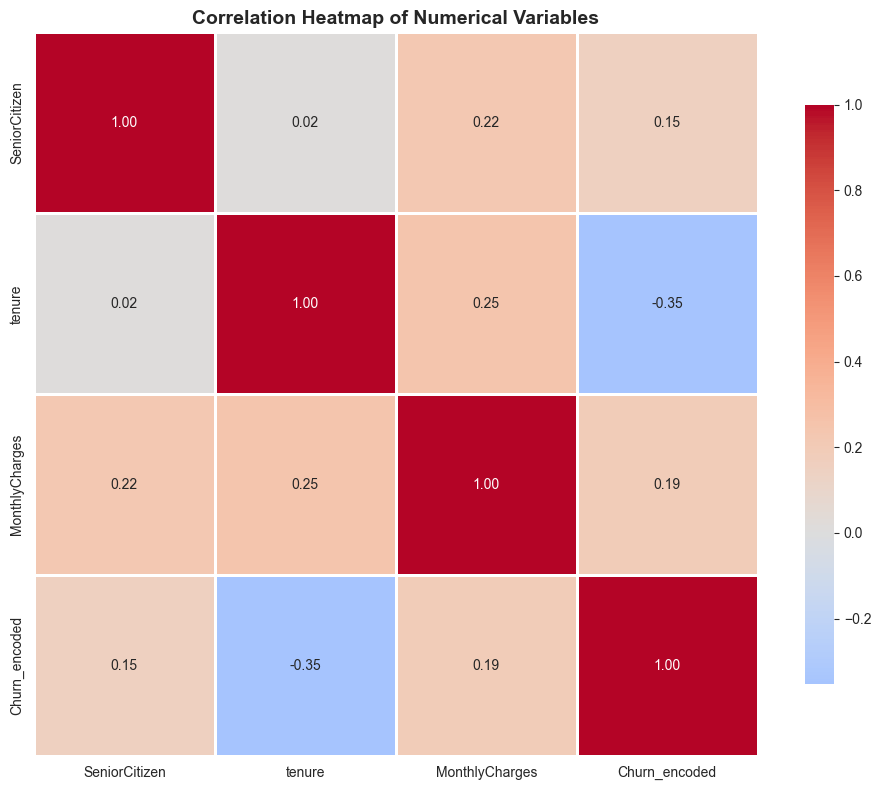


🎯 Correlation with Churn (sorted by absolute value):
tenure           -0.352229
MonthlyCharges    0.193356
SeniorCitizen     0.150889
Name: Churn_encoded, dtype: float64


In [28]:
# Correlation Heatmap for Numerical Variables
print("="*80)
print("CORRELATION HEATMAP")
print("="*80)

# Create a copy and encode Churn for correlation
df_corr = df.copy()
df_corr['Churn_encoded'] = df_corr['Churn'].map({'Yes': 1, 'No': 0})

# Select numerical columns including encoded target
corr_cols = numerical_cols + ['Churn_encoded']
correlation_matrix = df_corr[corr_cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap of Numerical Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Display correlations with target
print("\n🎯 Correlation with Churn (sorted by absolute value):")
churn_corr = correlation_matrix['Churn_encoded'].drop('Churn_encoded').sort_values(key=abs, ascending=False)
print(churn_corr)

BOXPLOTS: NUMERICAL FEATURES vs CHURN


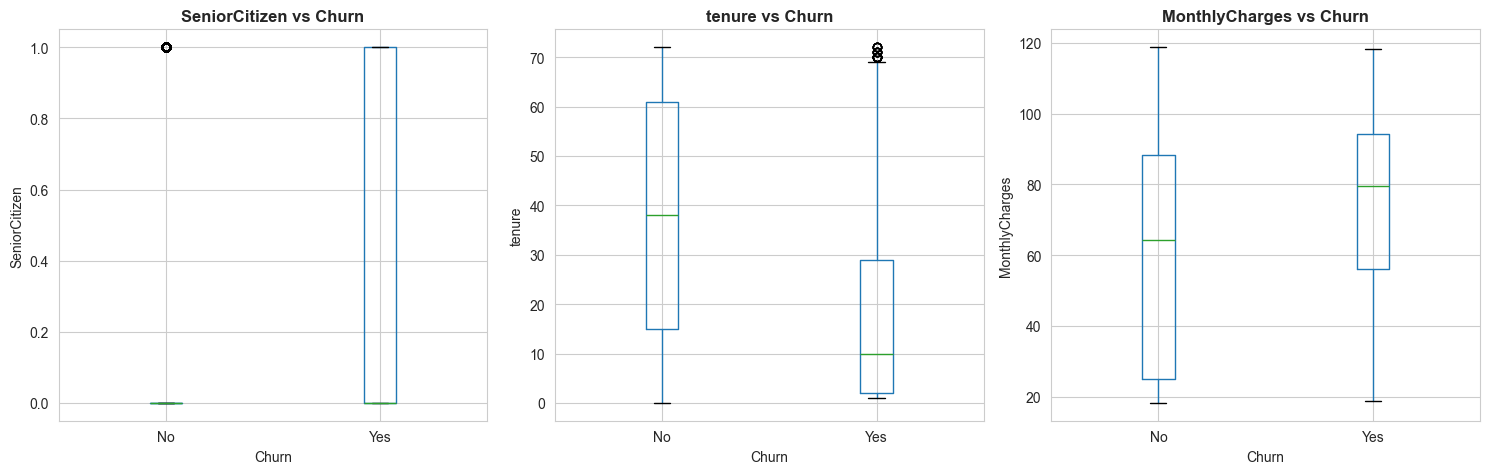


📊 Mean values by Churn status:
       SeniorCitizen     tenure  MonthlyCharges
Churn                                          
No          0.128721  37.569965       61.265124
Yes         0.254682  17.979133       74.441332


In [29]:
# Boxplots: Relationship between Numerical Features and Churn
print("="*80)
print("BOXPLOTS: NUMERICAL FEATURES vs CHURN")
print("="*80)

fig, axes = plt.subplots(1, len(numerical_cols), figsize=(15, 5))
if len(numerical_cols) == 1:
    axes = [axes]

for idx, col in enumerate(numerical_cols):
    df.boxplot(column=col, by='Churn', ax=axes[idx])
    axes[idx].set_title(f'{col} vs Churn', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Churn')
    axes[idx].set_ylabel(col)
    plt.sca(axes[idx])
    plt.xticks([1, 2], ['No', 'Yes'])

plt.suptitle('')  # Remove the default title
plt.tight_layout()
plt.show()

# Statistical comparison
print("\n📊 Mean values by Churn status:")
print(df.groupby('Churn')[numerical_cols].mean())

## Phase 2: Data Preprocessing 

### Handling Missing Values and Data Cleaning

In [30]:
# Create a working copy of the dataset
df_processed = df.copy()

print("="*80)
print("DATA PREPROCESSING")
print("="*80)

# Remove customerID as it's not useful for prediction
if 'customerID' in df_processed.columns:
    df_processed = df_processed.drop('customerID', axis=1)
    print("✓ Removed customerID column")

# Check for missing values
print(f"\n📊 Missing values before handling:")
missing_before = df_processed.isnull().sum()
print(missing_before[missing_before > 0])

# Handle TotalCharges if it's object type (common issue in this dataset)
if df_processed['TotalCharges'].dtype == 'object':
    print("\n⚠️ TotalCharges is object type - converting to numeric...")
    # Convert TotalCharges to numeric, coercing errors to NaN
    df_processed['TotalCharges'] = pd.to_numeric(df_processed['TotalCharges'], errors='coerce')
    print(f"✓ Converted TotalCharges to numeric")
    print(f"  Missing values created: {df_processed['TotalCharges'].isnull().sum()}")

# Imputation Strategy for TotalCharges
# Justification: For customers with 0 tenure, TotalCharges should be 0
# For others, we'll use median imputation based on similar MonthlyCharges
print("\n📝 Imputation Strategy:")
print("  - Customers with tenure=0 and missing TotalCharges → Fill with 0")
print("  - Others → Fill with median TotalCharges")

if df_processed['TotalCharges'].isnull().any():
    # Fill missing TotalCharges for tenure=0 customers with 0
    df_processed.loc[(df_processed['TotalCharges'].isnull()) & (df_processed['tenure'] == 0), 'TotalCharges'] = 0
    
    # Fill remaining missing values with median
    median_total_charges = df_processed['TotalCharges'].median()
    df_processed['TotalCharges'].fillna(median_total_charges, inplace=True)
    print(f"✓ Imputed missing TotalCharges values")

print(f"\n✅ Missing values after handling:")
missing_after = df_processed.isnull().sum()
if missing_after.sum() == 0:
    print("  No missing values remaining!")
else:
    print(missing_after[missing_after > 0])

print(f"\n📊 Final dataset shape: {df_processed.shape}")

DATA PREPROCESSING
✓ Removed customerID column

📊 Missing values before handling:
Series([], dtype: int64)

⚠️ TotalCharges is object type - converting to numeric...
✓ Converted TotalCharges to numeric
  Missing values created: 11

📝 Imputation Strategy:
  - Customers with tenure=0 and missing TotalCharges → Fill with 0
  - Others → Fill with median TotalCharges
✓ Imputed missing TotalCharges values

✅ Missing values after handling:
  No missing values remaining!

📊 Final dataset shape: (7043, 20)


### Encoding and Scaling 

In [31]:
# Identify binary and multi-category variables
print("="*80)
print("ENCODING CATEGORICAL VARIABLES")
print("="*80)

# Get all categorical columns (excluding target)
cat_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
if 'Churn' in cat_cols:
    cat_cols.remove('Churn')

# Identify binary variables (2 unique values)
binary_cols = [col for col in cat_cols if df_processed[col].nunique() == 2]
multi_cols = [col for col in cat_cols if df_processed[col].nunique() > 2]

print(f"\n📋 Binary Columns ({len(binary_cols)}): {binary_cols}")
print(f"📋 Multi-category Columns ({len(multi_cols)}): {multi_cols}")

# Label Encoding for binary variables
print("\n🔹 Applying Label Encoding to binary variables...")
le = LabelEncoder()
for col in binary_cols:
    df_processed[col] = le.fit_transform(df_processed[col])
    print(f"  ✓ {col}: {df_processed[col].unique()}")

# Encode target variable (Churn)
print("\n🎯 Encoding target variable (Churn)...")
df_processed['Churn'] = df_processed['Churn'].map({'No': 0, 'Yes': 1})
print(f"  ✓ Churn: {df_processed['Churn'].unique()}")

# One-Hot Encoding for multi-category variables
print("\n🔸 Applying One-Hot Encoding to multi-category variables...")
df_processed = pd.get_dummies(df_processed, columns=multi_cols, drop_first=True)
print(f"  ✓ Created {len([col for col in df_processed.columns if any(mc in col for mc in multi_cols)])} dummy variables")

print(f"\n📊 Dataset shape after encoding: {df_processed.shape}")
print(f"📋 New columns sample: {df_processed.columns.tolist()[:10]}...")

ENCODING CATEGORICAL VARIABLES

📋 Binary Columns (5): ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
📋 Multi-category Columns (10): ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']

🔹 Applying Label Encoding to binary variables...
  ✓ gender: [0 1]
  ✓ Partner: [1 0]
  ✓ Dependents: [0 1]
  ✓ PhoneService: [0 1]
  ✓ PaperlessBilling: [1 0]

🎯 Encoding target variable (Churn)...
  ✓ Churn: [0 1]

🔸 Applying One-Hot Encoding to multi-category variables...
  ✓ Created 21 dummy variables

📊 Dataset shape after encoding: (7043, 31)
📋 New columns sample: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn']...


In [32]:
# Scaling Numerical Features
print("="*80)
print("SCALING NUMERICAL FEATURES")
print("="*80)

# Identify numerical columns (excluding target)
num_cols = df_processed.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'Churn' in num_cols:
    num_cols.remove('Churn')

print(f"\n📊 Numerical columns to scale: {num_cols}")

# Use StandardScaler (z-score normalization)
print("\n🔧 Applying StandardScaler (z-score normalization)...")
scaler = StandardScaler()

# Store original values for comparison
original_values = df_processed[num_cols].head()

# Apply scaling
df_processed[num_cols] = scaler.fit_transform(df_processed[num_cols])

print("✓ Scaling completed!")
print(f"\n📈 Before scaling (first 5 rows):")
print(original_values)
print(f"\n📉 After scaling (first 5 rows):")
print(df_processed[num_cols].head())

print(f"\n📊 Final preprocessed dataset shape: {df_processed.shape}")
print("✅ Preprocessing completed successfully!")

SCALING NUMERICAL FEATURES

📊 Numerical columns to scale: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges']

🔧 Applying StandardScaler (z-score normalization)...
✓ Scaling completed!

📈 Before scaling (first 5 rows):
   gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0       0              0        1           0       1             0   
1       1              0        0           0      34             1   
2       1              0        0           0       2             1   
3       1              0        0           0      45             0   
4       0              0        0           0       2             1   

   PaperlessBilling  MonthlyCharges  TotalCharges  
0                 1           29.85         29.85  
1                 0           56.95       1889.50  
2                 1           53.85        108.15  
3                 0           42.30       1840.75  
4            

## Phase 3: Feature Engineering & Selection 

### Feature Engineering 

In [ ]:
# Feature Engineering - Creating New Meaningful Features
print("="*80)
print("FEATURE ENGINEERING")
print("="*80)

# Before scaling, we need to work with original data for some features
# Let's reload and create features before full preprocessing
df_fe = df.copy()

# Remove customerID
if 'customerID' in df_fe.columns:
    df_fe = df_fe.drop('customerID', axis=1)

# Handle TotalCharges conversion - ensure it's always numeric
# Strip whitespace and replace empty strings with NaN if it's object type
if df_fe['TotalCharges'].dtype == 'object':
    df_fe['TotalCharges'] = df_fe['TotalCharges'].str.strip().replace(['', ' '], np.nan)

# Always convert to numeric (handles both object and any other problematic types)
df_fe['TotalCharges'] = pd.to_numeric(df_fe['TotalCharges'], errors='coerce')

# Fill missing values
df_fe.loc[(df_fe['TotalCharges'].isnull()) & (df_fe['tenure'] == 0), 'TotalCharges'] = 0
df_fe['TotalCharges'].fillna(df_fe['TotalCharges'].median(), inplace=True)

# Verify the conversion was successful
print(f"Done TotalCharges converted to {df_fe['TotalCharges'].dtype}")

print("\nCreating New Features:")

# Feature 1: Average Monthly Charge per Tenure Month
# Insight: How much customer pays on average per month of their relationship
df_fe['AvgChargePerTenureMonth'] = df_fe['TotalCharges'] / (df_fe['tenure'] + 1)  # +1 to avoid division by zero
print("  ✓ Created 'AvgChargePerTenureMonth': TotalCharges / (tenure + 1)")

# Feature 2: Tenure Groups (Binning)
# Insight: Categorize customers by loyalty duration
def tenure_group(tenure):
    if tenure <= 12:
        return 0  # 'New'
    elif tenure <= 24:
        return 1  # 'Medium'
    elif tenure <= 48:
        return 2  # 'Established'
    else:
        return 3  # 'Long-term'

df_fe['TenureGroup'] = df_fe['tenure'].apply(tenure_group)
print("  Done - Created 'TenureGroup': 0=New(0-12mo), 1=Medium(13-24mo), 2=Established(25-48mo), 3=Long-term(48+mo)")

# Feature 3: Has Multiple Services
# Insight: Customers with more services might be less likely to churn
services = ['PhoneService', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
            'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df_fe['ServiceCount'] = 0
for service in services:
    if service in df_fe.columns:
        if service == 'InternetService':
            df_fe['ServiceCount'] += (df_fe[service] != 'No').astype(int)
        else:
            df_fe['ServiceCount'] += (df_fe[service] == 'Yes').astype(int)
print("  Done - Created 'ServiceCount': Total number of services subscribed")

# Feature 4: Charge Ratio
# Insight: How much of total charges comes from monthly charges
df_fe['ChargeRatio'] = df_fe['MonthlyCharges'] / (df_fe['TotalCharges'] + 1)  # +1 to avoid division by zero
print("  Done - Created 'ChargeRatio': MonthlyCharges / TotalCharges")

print(f"\n Dataset shape after feature engineering: {df_fe.shape}")
print("\n Sample of new features:")
print(df_fe[['tenure', 'TenureGroup', 'AvgChargePerTenureMonth', 'ServiceCount', 'ChargeRatio']].head(10))

In [ ]:
# Encode and prepare data with engineered features
print("="*80)
print("ENCODING DATA WITH NEW FEATURES")
print("="*80)

# Encode target
df_fe['Churn'] = df_fe['Churn'].map({'No': 0, 'Yes': 1})

# Encode binary variables
binary_cols_fe = [col for col in df_fe.select_dtypes(include=['object']).columns if df_fe[col].nunique() == 2]
le = LabelEncoder()
for col in binary_cols_fe:
    df_fe[col] = le.fit_transform(df_fe[col])

# One-hot encode multi-category variables
multi_cols_fe = [col for col in df_fe.select_dtypes(include=['object']).columns if df_fe[col].nunique() > 2]
df_fe = pd.get_dummies(df_fe, columns=multi_cols_fe, drop_first=True)

print(f"Encoding completed")
print(f"Final shape: {df_fe.shape}")

# Separate features and target
X = df_fe.drop('Churn', axis=1)
y = df_fe['Churn']

print(f"\n Features shape: {X.shape}")
print(f" Target shape: {y.shape}")
print(f" Target distribution:\n{y.value_counts()}")

### Feature Selection

Using both filter-based and model-based approaches

In [ ]:
# Method 1: Filter-based - ANOVA F-test (for numerical features)
print("="*80)
print("FILTER-BASED FEATURE SELECTION (ANOVA F-test)")
print("="*80)

# Apply SelectKBest with ANOVA F-test
k_best = 15  # Select top 15 features
selector_anova = SelectKBest(score_func=f_classif, k=k_best)
selector_anova.fit(X, y)

# Get feature scores
feature_scores_anova = pd.DataFrame({
    'Feature': X.columns,
    'Score': selector_anova.scores_
}).sort_values(by='Score', ascending=False)

print(f"\n Top 15 Features by ANOVA F-test:")
print(feature_scores_anova.head(15))

# Get selected features
selected_features_anova = feature_scores_anova.head(k_best)['Feature'].tolist()
print(f"\n Done - Selected {len(selected_features_anova)} features using ANOVA")

# Visualize top 15 features
plt.figure(figsize=(12, 6))
top_15 = feature_scores_anova.head(15)
plt.barh(range(len(top_15)), top_15['Score'])
plt.yticks(range(len(top_15)), top_15['Feature'])
plt.xlabel('ANOVA F-Score')
plt.title('Top 15 Features by ANOVA F-test', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# Method 2: Model-based - Random Forest Feature Importance
print("="*80)
print("MODEL-BASED FEATURE SELECTION (Random Forest)")
print("="*80)

# Train Random Forest for feature importance
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_selector.fit(X, y)

# Get feature importances
feature_importance_rf = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_selector.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(f"\n Top 15 Features by Random Forest Importance:")
print(feature_importance_rf.head(15))

# Get selected features
selected_features_rf = feature_importance_rf.head(k_best)['Feature'].tolist()
print(f"\nDone - Selected {len(selected_features_rf)} features using Random Forest")

# Visualize top 15 features
plt.figure(figsize=(12, 6))
top_15_rf = feature_importance_rf.head(15)
plt.barh(range(len(top_15_rf)), top_15_rf['Importance'], color='forestgreen')
plt.yticks(range(len(top_15_rf)), top_15_rf['Feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Features by Random Forest Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# Combine and finalize feature selection
print("="*80)
print("FINAL FEATURE SELECTION")
print("="*80)

# Find common features between both methods
common_features = list(set(selected_features_anova) & set(selected_features_rf))
print(f"\n Common features in both methods: {len(common_features)}")
print(common_features)

# Combine top features from both methods (union of top 10 from each)
top_10_anova = selected_features_anova[:10]
top_10_rf = selected_features_rf[:10]
final_features = list(set(top_10_anova + top_10_rf))

print(f"\n Final Selected Features ({len(final_features)}):")
for i, feat in enumerate(final_features, 1):
    in_anova = "✓" if feat in top_10_anova else " "
    in_rf = "✓" if feat in top_10_rf else " "
    print(f"  {i:2d}. {feat:40s} [ANOVA: {in_anova}] [RF: {in_rf}]")

print("\n" + "="*80)
print("JUSTIFICATION FOR FINAL FEATURE SELECTION:")
print("="*80)
print("""
We selected the final feature subset using a hybrid approach:

1. **Filter-based (ANOVA F-test)**: Identifies features with strong statistical
   relationships with the target variable, independent of any model.

2. **Model-based (Random Forest)**: Captures feature interactions and non-linear
   relationships that might be missed by statistical tests.

3. **Final Selection Strategy**: We took the union of top 10 features from each
   method to ensure we capture both statistically significant features and those
   with strong predictive power in ensemble models.

4. **Benefits of this approach**:
   - Reduces dimensionality while retaining predictive power
   - Combines statistical significance with practical predictive value
   - Includes our engineered features if they prove valuable
   - Reduces risk of overfitting and improves model generalization
   - Maintains model interpretability with manageable number of features
""")

In [ ]:
# Prepare final dataset with selected features
X_selected = X[final_features].copy()
y_final = y.copy()

print("="*80)
print("FINAL DATASET FOR MODELING")
print("="*80)
print(f"\n Features shape: {X_selected.shape}")
print(f" Target shape: {y_final.shape}")
print(f"\n Selected features: {X_selected.columns.tolist()}")

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_final, test_size=0.2, random_state=42, stratify=y_final
)

print(f"\n Data Split:")
print(f"  Training set: {X_train.shape[0]} samples")
print(f"  Test set: {X_test.shape[0]} samples")
print(f"\n  Training target distribution:")
print(f"    {y_train.value_counts()}")
print(f"  Test target distribution:")
print(f"    {y_test.value_counts()}")